# Master Informatique, parcours Data Mining

### Carnets de note Python pour le cours de Text Mining

Julien Velcin, laboratoire ERIC, Université Lyon 2

# Visualisation (partie 3)

In [1]:
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import cm 
import os
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
import pandas

## Dictionnaire et corpus

In [2]:
# lecture des données pour un fichier texte simple
with open(os.path.join("datasets", "Frank Herbert - Dune.txt")) as f:
    lines = [line.strip() for line in f.readlines()]
doc_set = lines

# fonction qui génère les listes de mots (token) à partir des textes
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# on construit le corpus
data_words = list(sent_to_words(doc_set))
# nombre total de documents
ndocs = len(data_words)

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# on retire les mots-outils
data_words_nostops = remove_stopwords(data_words)

# création du dictionnaire
dico = corpora.Dictionary(data_words_nostops)

# ce qui permet par ex. de filtrer le vocabulaire
dico.filter_extremes(no_below=10)

# Create Corpus
texts = data_words_nostops

# matrice Term Document Frequency
corpus = [dico.doc2bow(text) for text in texts]

In [4]:
ntopics = 50
temp_file = "models/model_dataconf_" + str(ntopics)
ldamodel = LdaModel.load(temp_file)  

In [5]:
pwz = ldamodel.get_topics()

print("On peut récupérer la matrice stockant p(w/z):", pwz.shape)

# on peut aussi utiliser ldamodel.get_topic_terms(topicid, topn=n) pour obtenir
# les top n mots via leur identifiant, accompagnés de la proba p(w/z)

#ldamodel.get_topic_terms(1,topn=len(dico))

On peut récupérer la matrice stockant p(w/z): (50, 1809)


In [6]:
# show_topics permet d'afficher les mots directement
ldamodel.show_topics(num_topics=ntopics,formatted=False)

[(0,
  [('fremen', 0.39084002),
   ('use', 0.059228238),
   ('wish', 0.045204528),
   ('al', 0.038892522),
   ('desert', 0.033557408),
   ('live', 0.028252507),
   ('remember', 0.02324076),
   ('clear', 0.02114224),
   ('one', 0.020718865),
   ('different', 0.018741386)]),
 (1,
  [('duke', 0.2072339),
   ('leto', 0.08744753),
   ('atreides', 0.07339103),
   ('son', 0.07011205),
   ('said', 0.056533955),
   ('alia', 0.049839783),
   ('daughter', 0.033081464),
   ('long', 0.032318622),
   ('one', 0.028043028),
   ('thus', 0.027558316)]),
 (2,
  [('gurney', 0.19005096),
   ('halleck', 0.09838473),
   ('said', 0.06477322),
   ('go', 0.063096724),
   ('called', 0.05653797),
   ('paul', 0.0520262),
   ('made', 0.043887354),
   ('man', 0.029949298),
   ('instant', 0.023104072),
   ('darkness', 0.02247189)]),
 (3,
  [('know', 0.14811775),
   ('said', 0.106028765),
   ('old', 0.09817265),
   ('woman', 0.07485444),
   ('lord', 0.07103217),
   ('yes', 0.061214544),
   ('ah', 0.044197567),
   ('yo

On peut vérifier que les mots ont une probabilité d'appartenir à *plusieurs* thématiques

# jolie visualisation avec pyLDAvis

Attention, les thématiques sont remunérotées.

In [7]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, gensim.matutils.corpus2csc(corpus), dictionary=ldamodel.id2word)
#vis
pyLDAvis.display(vis)

Si on souhaite obtenir p(z|d), il faut réexécuter le modèle sur les données (par ex., le corpus).

In [8]:
ldc = ldamodel[corpus]

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Les procédures suivantes fournissent plusieurs "vues" intéressantes sur le modèle. Elles viennent du site *machinelearningplus.com* :

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Tout d'abord, on souhaite un tableau qui liste la thématique majoritaire pour chaque document, accompagnée par ses mots les plus probables.

In [9]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    i=0
    for i, row in enumerate(ldamodel[corpus]):         
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=doc_set)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,28.0,0.51,"people, thopter, dune, paul, hidden, strength,...",Dune
1,1,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",Frank Herbert
2,2,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",
3,3,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",Copyright 1965
4,4,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",
5,5,49.0,0.51,"high, small, presently, family, major, obvious...",Book 1
6,6,28.0,0.51,"people, thopter, dune, paul, hidden, strength,...",DUNE
7,7,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",
8,8,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",= = = = = =
9,9,0.0,0.02,"fremen, use, wish, al, desert, live, remember,...",


On peut vouloir obtenir les documents les plus "représentatifs" de chaque thématique (attention, au sens de p(z|d)).

In [10]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7550,"fremen, use, wish, al, desert, live, remember,...","""Lisan al-Gaib!"""
1,1.0,0.7800,"duke, leto, atreides, son, said, alia, daughte...","Jessica spoke bitterly: ""Chips in the path of ..."
2,2.0,0.8367,"gurney, halleck, said, go, called, paul, made,...","And Paul: ""Gurney, man! Gurney, man!"""
3,3.0,0.7550,"know, said, old, woman, lord, yes, ah, young, ...","""When we've rested,"" Jessica said, ""we should ..."
4,4.0,0.6733,"saw, another, felt, paul, thing, someone, jess...","Paul collapsing their tent, recovering it up t..."
5,5.0,0.8040,"mother, reverend, noted, attention, power, oft...","""Reverend Mother!"" Chani said. ""What is wrong?"""
6,6.0,0.7550,"poison, get, hold, message, melange, said, rea...","""I'm perfectly safe here,"" Paul said."
7,7.0,0.7550,"asked, idaho, paul, basin, jessica, green, wil...","""Are there any plants down there?"" Paul asked."
8,8.0,0.9423,"rock, light, sand, moved, hulud, shai, across,...","Slowly, the filtered sun buried itself beneath..."
9,9.0,0.7550,"guild, yet, imperium, human, slowly, report, m...","""I'm a soldier of the Imperium,"" Paul said, ""t..."


Pour finir, le "volume" estimé de documents (en réalité, de mots) couverts par les différentes thématiques.

In [11]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
dim_space = ntopics

doc_vec = np.zeros(shape=(ndocs,dim_space))
#id_docs_nonvides = []

for i, d in enumerate(ldamodel[corpus]):
    for j, (topic, poids) in enumerate(d[0]):
        doc_vec[i, topic] = poids


/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Callable


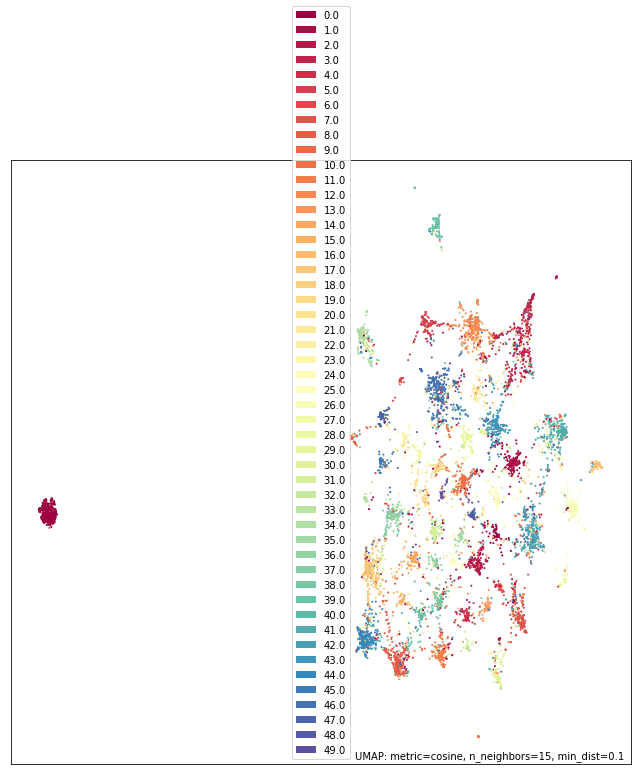

In [13]:
import umap
import umap.plot
mapper_lda = umap.UMAP(metric='cosine').fit(doc_vec)
umap.plot.points(mapper_lda, labels=np.array(df_dominant_topic.Dominant_Topic))

hover_data = pd.DataFrame({'index': np.arange(1, ndocs+1),
                           'label': [doc_set[i] for i in range(ndocs)],
                           'topic': df_dominant_topic.Dominant_Topic})
#p = umap.plot.interactive(mapper, labels=id_docs_nonvides, hover_data=hover_data, point_size=2)
#p = umap.plot.interactive(mapper_lda, hover_data=hover_data, point_size=2)
p = umap.plot.interactive(mapper_lda, labels=df_dominant_topic.Dominant_Topic, hover_data=hover_data, point_size=2)
umap.plot.show(p)

## Post-traitement

In [14]:
topic_tohide = [1, 5, 6, 13, 39]

doc_filtered = [id_doc for id_doc in range(ndocs) if len(corpus[id_doc])>2 and df_dominant_topic.Dominant_Topic[id_doc] not in topic_tohide]

len(doc_filtered)

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6476

In [15]:
mapper_lda_small = umap.UMAP(metric='cosine').fit(doc_vec[doc_filtered])

hover_data = pd.DataFrame({'index': [i+1 for i in doc_filtered],
                           'label': [doc_set[i] for i in doc_filtered],
                           'topic': [df_dominant_topic.Dominant_Topic[i] for i in doc_filtered]})
p = umap.plot.interactive(mapper_lda_small, labels=[df_dominant_topic.Dominant_Topic[i] for i in doc_filtered], hover_data=hover_data, point_size=2)
umap.plot.show(p)

/Users/julien/anaconda3/envs/cours/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<img src="img/visu_topics.png" style='height: 400px'/>